In [16]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')



In [2]:
import sys
sys.path.append('../../')

In [3]:
from codes.docs.analysis import data_preprocessing, logging_outputs

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
%matplotlib inline

# 1. Data Preprocessing and Importing

In [5]:
full_dataset=pd.read_excel(open('./dataset/allSubjectsWithKANA_AALVolumes_mm3_4Harriet_withCovariates_withImperialLegendsOK.xlsx','rb'),sheet_name='allSubjectsWithKANA_AALVolumes').drop('ID',axis=1)
full_dataset=full_dataset.rename({'Subject':'ID'},axis=1)

In [6]:
Imperial_label=pd.read_excel(open('./dataset/allSubjectsWithKANA_AALVolumes_mm3_4Harriet_withCovariates_withImperialLegendsOK.xlsx','rb'),sheet_name='IMPERIAL ROIs LEGEND',header=None).drop([0,1],axis=1)
AAL_label=pd.read_excel(open('./dataset/allSubjectsWithKANA_AALVolumes_mm3_4Harriet_withCovariates_withImperialLegendsOK.xlsx','rb'),sheet_name='AAL LEGEND',header=None).drop(0,axis=1)

In [7]:
from string import digits
AAL_label=np.asarray([str.split(i,' ')[1] for i in np.asarray(AAL_label).reshape(-1)])
Imperial_label=np.asarray([str.strip(i.translate({ord(c): None for c in digits})) for i in (np.asarray(Imperial_label)).reshape(-1)])

In [8]:
#Reading necessary tables
schizophrenia_high_scores_european=data_preprocessing.read_table_from_txt('./dataset/SCZ2_lifted37_dHCP_merged_cleaned_EUROPEANS.gwas.all.score',add_EP=False)
ancestral_PCA_european=data_preprocessing.read_table_from_txt('./dataset/file3_only_europ_10pcs_pca.eigenvec',add_EP=False)

In [9]:
#Merge the tables together using the european ID as the key.
from functools import reduce
european_ID_dataset=reduce(lambda left,right: pd.merge(left,right,on='ID',how='inner'),[full_dataset,schizophrenia_high_scores_european,ancestral_PCA_european])
#retain the last session in cases of duplication
european_ID_dataset=european_ID_dataset.drop_duplicates(subset='ID',keep='last')
european_ID_dataset=european_ID_dataset.reset_index(drop=True)


Summary statistics for the dHCP cohort:

In [10]:
def print_summary_statistics(df,*args):
    return ('%.1f \u00B1 %.1f' % (df[args[0]].mean(),df[args[0]].std()))

pd.DataFrame({'Ancestry':['European (term)','European (preterm)','Mixed Cohort Sample'],'Number of subjects':[202,67,750],
'Mean Gestational Age(weeks)':
[print_summary_statistics(european_ID_dataset[european_ID_dataset['GA at birth']>37],'GA at birth'),
print_summary_statistics(european_ID_dataset[european_ID_dataset['GA at birth']<=37],'GA at birth'),
print_summary_statistics(full_dataset,'GA at birth')],
'Mean PMA at scan':
[print_summary_statistics(european_ID_dataset[european_ID_dataset['GA at birth']>37],'PMA at birth'),
print_summary_statistics(european_ID_dataset[european_ID_dataset['GA at birth']<=37],'PMA at birth'),
print_summary_statistics(full_dataset,'PMA at birth')],
'Mean ICV (mm3)':[print_summary_statistics(european_ID_dataset[european_ID_dataset['GA at birth']>37],'17 ICV (all except bone)'),
print_summary_statistics(european_ID_dataset[european_ID_dataset['GA at birth']<=37],'17 ICV (all except bone)'),
print_summary_statistics(full_dataset,'17 ICV (all except bone)')]})

,Ancestry,Number of subjects,Mean Gestational Age(weeks),Mean PMA at scan,Mean ICV (mm3)
0,European (term),202,40.1 ± 1.2,41.6 ± 1.7,457526.7 ± 63213.6
1,European (preterm),67,32.2 ± 3.8,39.1 ± 3.6,404412.5 ± 97061.3
2,Mixed Cohort Sample,750,37.4 ± 4.4,40.2 ± 3.1,424396.8 ± 84411.1


In [11]:
european_ID_dataset_term=european_ID_dataset[european_ID_dataset['GA at birth']>37].reset_index(drop=True)
european_ID_dataset_preterm=european_ID_dataset[european_ID_dataset['GA at birth']<=37].reset_index(drop=True)

## 1.2 Removing outliers


Note: when running change the dataset to term and preterm accordingly

The outliers are removed according to their first 2 ancestrial PC z-scores. Anything more than 2.5 standard deviation from the mean is removed.

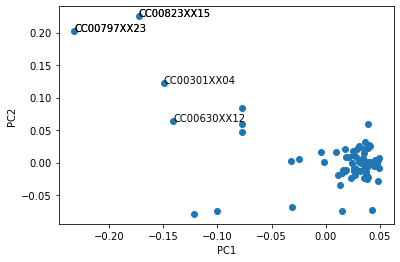

In [12]:
from scipy import stats
zscores=np.abs(stats.zscore(european_ID_dataset_preterm.loc[:,('PC1','PC2')].astype('float64'),axis=0))
outliers=np.where(zscores>=2.5)[0]#remove anything more than 2.5 st. deviation from the mean.

#removing outliers using the ancestrial PCA
fig,ax=plt.subplots()
ax.scatter(european_ID_dataset_preterm.loc[:,'PC1'],european_ID_dataset_preterm.loc[:,'PC2'])
for i,txt in enumerate(european_ID_dataset_preterm.loc[outliers,'ID']):
    ax.annotate(txt,(european_ID_dataset_preterm.loc[outliers[i],'PC1'],european_ID_dataset_preterm.loc[outliers[i],'PC2']))
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')

european_ID_dataset_without_outliers=european_ID_dataset_preterm.drop(outliers).reset_index(drop=True)

In [13]:
european_volumetric_AAL_matrix=np.asarray(european_ID_dataset_without_outliers.iloc[:,21:114])
european_volumetric_Imperial_matrix=np.asarray(european_ID_dataset_without_outliers.iloc[:,114:201])
european_ancestral_PCA=np.asarray(european_ID_dataset_without_outliers.iloc[:,212:222])
european_PRS_schizophrenia=np.asarray(european_ID_dataset_without_outliers.iloc[:,201:212])

In [14]:
#extracting ages, total volume, gender
european_age_at_scan=np.asarray(european_ID_dataset_without_outliers.iloc[:,3])
european_gestational_age=np.asarray(european_ID_dataset_without_outliers.iloc[:,2])
european_total_volume=np.asarray(european_ID_dataset_without_outliers.iloc[:,5])
european_icv=np.asarray(european_ID_dataset_without_outliers.iloc[:,4])

## 1.3 Adjusting for covariates

Text(0, 0.5, 'PC3')

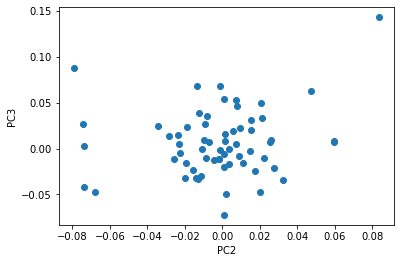

In [17]:
plt.scatter(european_ancestral_PCA[:,1],european_ancestral_PCA[:,2])
plt.xlabel('PC2')
plt.ylabel('PC3')
#check the PC1 vs. PC2, PC2 vs PC3, etc. until I see a structureless blob.

For PRS: I adjusted for the first 3 ancestral PCs.

For volumetric data: I adjusted for age at scan, at birth, intracranial volume, and total volume.

In [15]:
#adjusting for covariates:
#for PRS: I adjusted for 3 PCs. and for connectivity and structural data: I adjusted for age at scan, at birth, intracranial volume and gender. similar to Harriet's paper and Shi et al., 2012 (although this one has number of fibers regressed out as well).

adjusted_european_PRS_schizophrenia=data_preprocessing.adjusting_for_covariates_with_lin_reg(european_PRS_schizophrenia,european_ancestral_PCA[:,0:3])#adjust for the first 3 PCs.
adjusted_european_PRS_schizophrenia=adjusted_european_PRS_schizophrenia.astype('float64')

adjusted_european_volumetric_AAL_matrix=data_preprocessing.adjusting_for_covariates_with_lin_reg(european_volumetric_AAL_matrix,european_age_at_scan,european_gestational_age,european_icv,european_total_volume)
adjusted_european_volumetric_AAL_matrix=adjusted_european_volumetric_AAL_matrix.astype('float64')

adjusted_european_volumetric_Imperial_matrix=data_preprocessing.adjusting_for_covariates_with_lin_reg(european_volumetric_Imperial_matrix,european_age_at_scan,european_gestational_age,european_icv,european_total_volume)
adjusted_european_volumetric_Imperial_matrix=adjusted_european_volumetric_Imperial_matrix.astype('float64')

#remove the CSF, Extracranial and Intracranial volume from adjusted_european_volumetric_Imperial_matrix
adjusted_european_volumetric_Imperial_matrix=np.delete(adjusted_european_volumetric_Imperial_matrix,[82,83,84],axis=1)
Imperial_label=np.delete(Imperial_label,[82,83,84],axis=0)

#remove the WM from adjusted_european_structural_schizophrenia
adjusted_european_GM_volumetric_Imperial_matrix=np.delete(adjusted_european_volumetric_Imperial_matrix,[idx for idx,i in enumerate(Imperial_label) if 'WM' in i or 'Corpus' in i],axis=1)
Imperial_GM_labels=np.delete(Imperial_label,[idx for idx,i in enumerate(Imperial_label) if 'WM' in i or 'Corpus' in i],axis=0)

In [16]:
def name_of_global_obj(xx):
    return [objname for objname, oid in globals().items()
        if id(oid)==id(xx) and not objname.startswith('_')][0]
def save_to_npy(filepath,*args):
    for i in args:
        temp_name=filepath+name_of_global_obj(i)+'.npy'
        np.save(temp_name,i)

In [22]:
save_to_npy('./preprocessed_data/preterm/',adjusted_european_PRS_schizophrenia,european_PRS_schizophrenia,adjusted_european_volumetric_AAL_matrix,adjusted_european_volumetric_Imperial_matrix,Imperial_GM_labels,adjusted_european_GM_volumetric_Imperial_matrix, AAL_label,european_age_at_scan,european_gestational_age,european_icv)

In [23]:
! ls preprocessed_data/preterm/

AAL_label.npy
Imperial_GM_labels.npy
adjusted_european_GM_volumetric_Imperial_matrix.npy
adjusted_european_PRS_schizophrenia.npy
adjusted_european_volumetric_AAL_matrix.npy
adjusted_european_volumetric_Imperial_matrix.npy
european_PRS_schizophrenia.npy
european_age_at_scan.npy
european_gestational_age.npy
european_icv.npy
